# GENIE3: Experimenting with GENIE3

## A) Computationnal part

#### Modules Importation

In [1]:
from sklearn.tree import BaseDecisionTree
from sklearn.ensemble import *
from sklearn.metrics import *
from numpy import *
import time
from operator import itemgetter
from multiprocessing import Pool
import igraph
import os 
import re
import matplotlib.pyplot as plt
import pandas as pd

#### Computing feature importances in each regression problem 

In [2]:
def compute_feature_importances(estimator,tree_method):
    if isinstance(estimator, BaseDecisionTree):
        return estimator.tree_.compute_feature_importances(normalize=False)
    
    elif tree_method=='GB':
        return estimator.feature_importances_
    
    else:
        importances = [e.tree_.compute_feature_importances(normalize=False)
                       for e in estimator.estimators_]
        importances = asarray(importances)
        return sum(importances,axis=0) / len(estimator)

#### GENIE3 algorithm for every genes combination

In [4]:
def GENIE3(expr_data,gene_names=None,regulators='all',tree_method='RF',K='sqrt',ntrees=1000,nthreads=1,verbose=True):
    
    '''Computation of tree-based scores for all putative regulatory links.
    
    Parameters
    ----------
    
    expr_data: numpy array
        Array containing gene expression values. Each row corresponds to a condition and each column corresponds to a gene.
        
    gene_names: list of strings, optional
        List of length p, where p is the number of columns in expr_data, containing the names of the genes. The i-th item of gene_names must correspond to the i-th column of expr_data.
        default: None
        
    regulators: list of strings, optional
        List containing the names of the candidate regulators. When a list of regulators is provided, the names of all the genes must be provided (in gene_names). When regulators is set to 'all', any gene can be a candidate regulator.
        default: 'all'
        
    tree-method: 'RF' or 'ET', optional
        Specifies which tree-based procedure is used: either Random Forest ('RF') or Extra-Trees ('ET')
        default: 'RF'
        
    K: 'sqrt', 'all' or a positive integer, optional
        Specifies the number of selected attributes at each node of one tree: either the square root of the number of candidate regulators ('sqrt'), the total number of candidate regulators ('all'), or any positive integer.
        default: 'sqrt'
         
    ntrees: positive integer, optional
        Specifies the number of trees grown in an ensemble.
        default: 1000
    
    nthreads: positive integer, optional
        Number of threads used for parallel computing
        default: 1
        
        
    Returns
    -------

    An array in which the element (i,j) is the score of the edge directed from the i-th gene to the j-th gene. All diagonal elements are set to zero (auto-regulations are not considered). When a list of candidate regulators is provided, the scores of all the edges directed from a gene that is not a candidate regulator are set to zero.
        
    '''
    
    time_start = time.time()
    
    # Check input arguments
    if not isinstance(expr_data,ndarray):
        raise ValueError('expr_data must be an array in which each row corresponds to a condition/sample and each column corresponds to a gene')
        
    ngenes = expr_data.shape[1]
    
    if gene_names is not None:
        if not isinstance(gene_names,(list,tuple)):
            raise ValueError('input argument gene_names must be a list of gene names')
        elif len(gene_names) != ngenes:
            raise ValueError('input argument gene_names must be a list of length p, where p is the number of columns/genes in the expr_data')
        
    if regulators != 'all':
        if not isinstance(regulators,(list,tuple)):
            raise ValueError('input argument regulators must be a list of gene names')

        if gene_names is None:
            raise ValueError('the gene names must be specified (in input argument gene_names)')
        else:
            sIntersection = set(gene_names).intersection(set(regulators))
            if not sIntersection:
                raise ValueError('the genes must contain at least one candidate regulator')        
        
    if tree_method != 'RF' and tree_method != 'ET' and tree_method != 'GB' and tree_method != 'AB':
        raise ValueError('input argument tree_method must be "RF" (Random Forests) or "ET" (Extra-Trees)')
        
    if K != 'sqrt' and K != 'all' and not isinstance(K,int): 
        raise ValueError('input argument K must be "sqrt", "all" or a stricly positive integer')
        
    if isinstance(K,int) and K <= 0:
        raise ValueError('input argument K must be "sqrt", "all" or a stricly positive integer')
    
    if not isinstance(ntrees,int):
        raise ValueError('input argument ntrees must be a stricly positive integer')
    elif ntrees <= 0:
        raise ValueError('input argument ntrees must be a stricly positive integer')
        
    if not isinstance(nthreads,int):
        raise ValueError('input argument nthreads must be a stricly positive integer')
    elif nthreads <= 0:
        raise ValueError('input argument nthreads must be a stricly positive integer')
          
    print('Tree method: ' + str(tree_method))
    print('K: ' + str(K))
    print('Number of trees: ' + str(ntrees))
    print('\n')
        
    
    # Get the indices of the candidate regulators
    if regulators == 'all':
        input_idx = list(range(ngenes))
    else:
        input_idx = [i for i, gene in enumerate(gene_names) if gene in regulators]

    
    # Learn an ensemble of trees for each target gene, and compute scores for candidate regulators
    VIM = zeros((ngenes,ngenes))
    
    if nthreads > 1:
        if verbose==True:
            print('running jobs on %d threads' % nthreads)

        input_data = list()
        for i in range(ngenes):
            input_data.append( [expr_data,i,input_idx,tree_method,K,ntrees] )

        pool = Pool(nthreads)
        alloutput = pool.map(wr_GENIE3_single, input_data)
    
        for (i,vi) in alloutput:
            VIM[i,:] = vi

    else:
        if verbose==True:
            print('running single threaded jobs')
        for i in range(ngenes):
            if verbose==True:
                if i%10==0:
                    print('Gene %d/%d...' % (i+1,ngenes))
            
            vi = GENIE3_single(expr_data,i,input_idx,tree_method,K,ntrees)
            VIM[i,:] = vi

   
    VIM = transpose(VIM)
 
    time_end = time.time()
    if verbose==True:
        print("Elapsed time: %.2f seconds" % (time_end - time_start))

    return VIM

#### GENIE3 for a specific input gene

In [6]:
def GENIE3_single(expr_data,output_idx,input_idx,tree_method,K,ntrees):
    
    ngenes = expr_data.shape[1]
    
    # Expression of target gene
    output = expr_data[:,output_idx]
    
    # Normalize output data
    output = output / std(output)
    
    # Remove target gene from candidate regulators
    input_idx = input_idx[:]
    if output_idx in input_idx:
        input_idx.remove(output_idx)

    expr_data_input = expr_data[:,input_idx]
    
    # Parameter K of the tree-based method
    if (K == 'all') or (isinstance(K,int) and K >= len(input_idx)):
        max_features = "auto"
    else:
        max_features = K
    
    if tree_method == 'RF':
        treeEstimator = RandomForestRegressor(n_estimators=ntrees,max_features=max_features)
    elif tree_method == 'ET':
        treeEstimator = ExtraTreesRegressor(n_estimators=ntrees,max_features=max_features)  
    elif tree_method == 'GB':
        treeEstimator = GradientBoostingRegressor(n_estimators=ntrees,max_features=max_features)
    elif tree_method == 'AB':
        treeEstimator = AdaBoostRegressor(n_estimators=ntrees)
        
    treeEstimator.fit(expr_data_input,output)
    """
    elif tree_method == 'GB' or tree_method == 'AB':
        label_enc = preprocessing.LabelEncoder()
        output = label_enc.fit_transform(output)
        estimator.fit(expr_data_input,output)
    """
    # Compute importance scores
    #if tree_method == "RF" or tree_method == "ET":
    feature_importances = compute_feature_importances(treeEstimator,tree_method)
    
    #elif tree_method = "GB" or tree_method = "AB":
    #    feature_importances = compute_feature_importances
    
    vi = zeros(ngenes)
    vi[input_idx] = feature_importances
       
    return vi

#### Parsing DREAM4 dataset and generating training data

In [7]:
def GetFilePaths(rootPath):
    filesList=[]
    for root, dirs, files in os.walk(rootPath):
        for file in files:
            indexFiles=file.endswith("indexes.tsv")
            steadyFiles=file.endswith("steadyState.tsv")
            timeFiles=file.endswith("timeSeries.tsv")
            tsvFiles=file.endswith(".tsv")
            if  tsvFiles and not indexFiles and not steadyFiles and not timeFiles:
                filesList.append(os.path.join(root, file))
    return filesList

def WriteValues(rootPath):
    
    files=GetFilePaths(rootPath)
    fluxWriteSteady=open(rootPath+'steadyState.tsv','w')
    flagHeaderSteady=0
    regexHeaderSteady=".*G.*"
    
    fluxWriteTime=open(rootPath+'timeSeries.tsv','w')   
    
    for file in files:
        
        fluxRead=open(file,'r')
        lines=fluxRead.readlines()
        
        
        
        if file.endswith("timeseries.tsv"):
            for line in lines:
                fluxWriteTime.write(line)        
            
        else :
            
            if lines and flagHeaderSteady==0:
                if(re.match(regexHeaderSteady,lines[0])):
                    flagHeaderSteady=1
                    fluxWriteSteady.write(re.match(regexHeaderSteady,lines[0]).group(0)+'\n')
                    
            if flagHeaderSteady==1:
                lines=lines[1:]
            for line in lines:
                fluxWriteSteady.write(line)
                
        fluxRead.close()
        
    fluxWriteSteady.close()
    fluxWriteTime.close()
        
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_1/')
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_2/')
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_3/')
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_4/')
WriteValues('../../dream_data/training_data/InSilico_10/insilico_size10_5/')

#### Reading the true Networks 

In [8]:
def ReadGoldStandard(path):
    flux=open(path,'r')
    lignes=flux.readlines()
    connexionList=[]
    for ligne in lignes:
        listeTemp=ligne.split('\n')[0].split('\t')
        connexionList.append([int(listeTemp[0][1:]),int(listeTemp[1][1:]),int(listeTemp[2])])
    connexionList=array(connexionList)
    nbOfVariables=max(connexionList[:,0])
    correctionMatrix=zeros((nbOfVariables,nbOfVariables))
    for connexion in connexionList:
        correctionMatrix[connexion[0]-1,connexion[1]-1]=connexion[2]
    return correctionMatrix

In [10]:
#Getting Gene names
f = open('../../dream_data/training_data/InSilico_10/insilico_size10_1/steadyState.tsv')
gene_names = f.readline()
gene_names = gene_names.rstrip('\n').split('\t')
f.close()

In [82]:
def ScoresFromSteadyFile(steadyFilePath,trueNetworkFilePath,gene_names=None,regulators='all',tree_method='RF',K='sqrt',ntrees=1000,nthreads=1,verbose=True):
    
    """
    Calculate the AUPR and AUROC scores directly from:
    -The SteadyState files (training data) 
    -The Goldstandard files(correction)
    
    Returns the AUPR and AUROC score
    """
    
    #Loading the files
    data=loadtxt(steadyFilePath,skiprows=1)
    corrMatrix=ReadGoldStandard(trueNetworkFilePath)
    
    #Creating the inferred connetion matrix
    inferedMatrix=GENIE3(data,gene_names=None,regulators='all',tree_method=tree_method,K='sqrt',ntrees=1000,nthreads=1,verbose=verbose)

    #Calculating the PR curve
    precision,recall,treshold=precision_recall_curve(corrMatrix.flatten(),inferedMatrix.flatten())

    #Calculating the ROC curve
    fpr,tpr,tresholds=roc_curve(corrMatrix.flatten(),inferedMatrix.flatten())
    
    #Calculating the Area under the curve for PR
    AUPR=auc(recall,precision)
    #Calculating the areau under the curve for ROC
    AUROC=auc(fpr,tpr)
    
    
    print(AUROC)
    
    return [recall,precision],[fpr,tpr]

### Writing the results on file

Since computation is really time consuming, we chose to write the results of the evaluation of GENIE3 algorithm in a separate folder: generated_data

###### Setting paths, row names and column names

In [89]:
#Correction file paths
gold_1='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_1.tsv'
gold_2='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_2.tsv'
gold_3='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_3.tsv'
gold_4='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_4.tsv'
gold_5='../../dream_data/True_Network/Size_100_multifactorial/DREAM4_GoldStandard_InSilico_Size100_multifactorial_5.tsv'

#Training data paths
data_1='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_1_multifactorial.tsv'
data_2='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_2_multifactorial.tsv'
data_3='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_3_multifactorial.tsv'
data_4='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_4_multifactorial.tsv'
data_5='../../dream_data/training_data/InSilico_100_Multifactorial/insilico_size100_5_multifactorial.tsv'

#Search methods
searchMethods=["ET","RF","AB","GB"]
#Networks names
NETnames=["NET1","NET2","NET3","NET4","NET5"]

#Data Paths
dataPaths=[data_1,data_2,data_3,data_4,data_5]
#Correction Paths
corrPaths=[gold_1,gold_2,gold_3,gold_4,gold_5]

#OUTPUT Folder
pathGenerated='../../generated_data/'

###### Computation (time consuming part) and writing of results

In [90]:
#Scores by methods (first Axis) and paths (second Axis)
scoreAUPR=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]
scoreAUROC=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]

#ROC and PR values by methods (first Axis) and paths (second Axis)
valuesPR=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]
valuesROC=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]

for i in range(len(searchMethods)):
    for j in range(len(dataPaths)):
        valuesPR[i][j],valuesROC[i][j]=ScoresFromSteadyFile(dataPaths[j],
                                                            corrPaths[j],
                                                            tree_method=searchMethods[i],
                                                            verbose=False)
        
for i in range(len(searchMethods)):
    for j in range(len(dataPaths)):
        method=searchMethods[i]
        dataset=dataPaths[j]
        nomFiROC=pathGenerated+method+'_'+'NET_'+str(j+1)+'_ROC.txt'
        nomFiPR=pathGenerated+method+'_'+'NET_'+str(j+1)+'_PR.txt'
        savetxt(nomFiROC,array(valuesROC[i][j]),delimiter=',')
        savetxt(nomFiPR,array(valuesPR[i][j]),delimiter=',')

Tree method: ET
K: sqrt
Number of trees: 1000


0.7518565387177969
Tree method: ET
K: sqrt
Number of trees: 1000


0.7284006294895509
Tree method: ET
K: sqrt
Number of trees: 1000


0.7865955360294982
Tree method: ET
K: sqrt
Number of trees: 1000


0.7927396018066512
Tree method: ET
K: sqrt
Number of trees: 1000


0.7973225215572466
Tree method: RF
K: sqrt
Number of trees: 1000


0.7486477920491561
Tree method: RF
K: sqrt
Number of trees: 1000


0.7227803635833459
Tree method: RF
K: sqrt
Number of trees: 1000


0.776349063141516
Tree method: RF
K: sqrt
Number of trees: 1000


0.7910683187773877
Tree method: RF
K: sqrt
Number of trees: 1000


0.7977562817296093
Tree method: AB
K: sqrt
Number of trees: 1000


0.7331014491412498
Tree method: AB
K: sqrt
Number of trees: 1000


0.6757622223073403
Tree method: AB
K: sqrt
Number of trees: 1000


0.756726421632082
Tree method: AB
K: sqrt
Number of trees: 1000


0.7661380241580766
Tree method: AB
K: sqrt
Number of trees: 1000


0.75532439290746

#### Parsing the results from files

In [91]:
#Scores by methods (first Axis) and paths (second Axis)
scoreAUPRFromFile=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]
scoreAUROCFromFile=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]

#ROC and PR values by methods (first Axis) and paths (second Axis)
valuesPRFromFile=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]
valuesROCFromFile=[[[] for i in range(len(dataPaths))] for j in range(len(searchMethods)) ]

for i in range(len(searchMethods)):
    for j in range(len(dataPaths)):
        method=searchMethods[i]
        dataset=dataPaths[j]
        nomFiROC=pathGenerated+method+'_'+'NET_'+str(j+1)+'_ROC.txt'
        nomFiPR=pathGenerated+method+'_'+'NET_'+str(j+1)+'_PR.txt'
        valuesROCFromFile[i][j]=loadtxt(nomFiROC,delimiter=',')
        valuesPRFromFile[i][j]=loadtxt(nomFiPR,delimiter=',')

## B) Presentation Part

### 1) ROC Results

a) Area under curve

In [92]:
scoresROCFromFile=array([[ auc(valuesROCFromFile[j][i][0,:],valuesROCFromFile[j][i][1,:]) for i in range(len(dataPaths))] for j in range(len(searchMethods))])
tableROCScore=pd.DataFrame(scoresROCFromFile,index=searchMethods,columns=NETnames)

display(tableROCScore)

,NET1,NET2,NET3,NET4,NET5
ET,0.751857,0.728401,0.786596,0.792740,0.797323
RF,0.748648,0.722780,0.776349,0.791068,0.797756
AB,0.733101,0.675762,0.756726,0.766138,0.755324
GB,0.699632,0.663569,0.744826,0.760662,0.731021


b) Curves

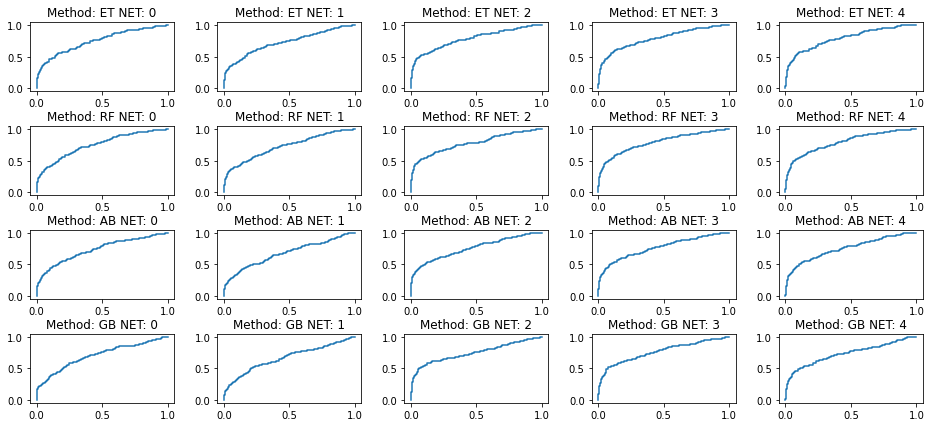

In [97]:
#Creating Figure
fig,axs=plt.subplots(len(searchMethods),len(NETnames),figsize=(16,7))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

#Filling the subplots
for i in range(len(searchMethods)):
    for j in range(len(NETnames)):
        axs[i,j].plot(valuesROCFromFile[i][j][0,:],valuesROCFromFile[i][j][1,:])
        axs[i,j].set_title("Method: "+searchMethods[i]+' '+'NET: '+str(j))

### 2) PR Results

a) Area under curve

In [94]:
scoresPRFromFile=array([[ auc(valuesPRFromFile[j][i][0,:],valuesPRFromFile[j][i][1,:]) for i in range(len(dataPaths))] for j in range(len(searchMethods))])
tablePRScore=pd.DataFrame(scoresPRFromFile,index=searchMethods,columns=NETnames)

display(tablePRScore)

,NET1,NET2,NET3,NET4,NET5
ET,0.137174,0.154357,0.220164,0.190827,0.174472
RF,0.153808,0.152742,0.218177,0.208720,0.195291
AB,0.118425,0.127231,0.207292,0.202043,0.139994
GB,0.117907,0.094273,0.184419,0.170073,0.133148


b) Curves

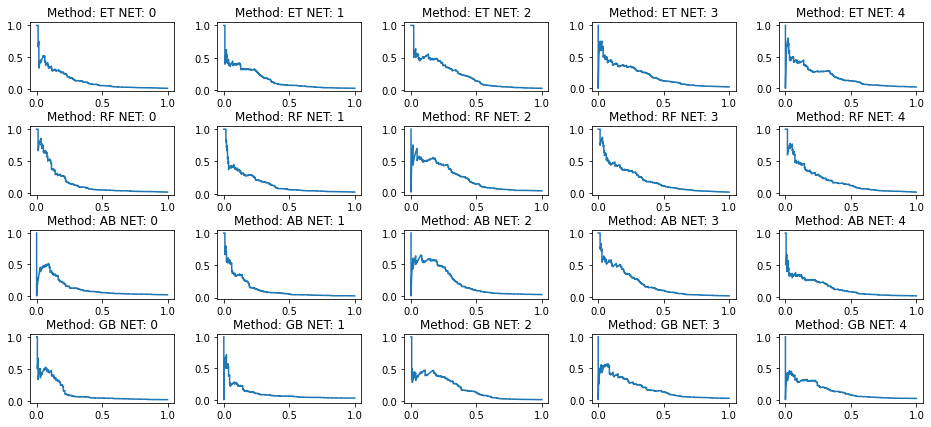

In [95]:
#Creating Figure
fig,axs=plt.subplots(len(searchMethods),len(NETnames),figsize=(16,7))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

#Filling the subplots
for i in range(len(searchMethods)):
    for j in range(len(NETnames)):
        axs[i,j].plot(valuesPRFromFile[i][j][0,:],valuesPRFromFile[i][j][1,:])
        axs[i,j].set_title("Method: "+searchMethods[i]+' '+'NET: '+str(j))

In [19]:
#Plotting a Graph
data=loadtxt(data_1,skiprows=1)
VIM=GENIE3(data,gene_names=None,regulators='all',tree_method='RF',K='sqrt',ntrees=1000,nthreads=1)
conn_indices = where(VIM) 
weights = VIM[conn_indices]
edges = zip(*conn_indices)
g=igraph.Graph(directed=True,edges=edges)
g.es['weight']=VIM
g.es["width"]=weights * 4
g.vs['label']=gene_names

Tree method: RF
K: sqrt
Number of trees: 1000


running single threaded jobs
Gene 1/100...
Gene 11/100...
Gene 21/100...
Gene 31/100...
Gene 41/100...
Gene 51/100...
Gene 61/100...
Gene 71/100...
Gene 81/100...
Gene 91/100...
Elapsed time: 147.59 seconds


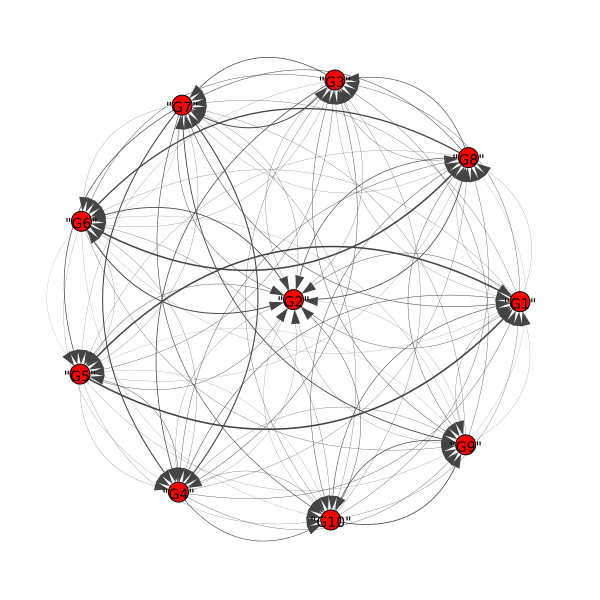

In [17]:
igraph.plot(g,labels=True,margin=80)

In [48]:
a=[0,12,34]
b=[1,2,3,4]

b.index(0)
a.index(0)

0